In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

from skimage import io

### 2D Convolution

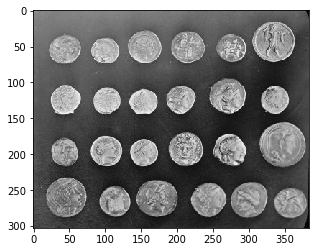

In [2]:
IMG_URL = 'https://github.com/scikit-image/scikit-image/raw/master/skimage/data/coins.png'
test_image = io.imread(IMG_URL) / 255

if len(test_image.shape) == 2:
    # gray-scale image
    test_image = np.repeat(np.expand_dims(test_image, -1), 3, axis=-1)

test_image = np.expand_dims(test_image, 0)
plt.imshow(test_image[0][:,:,0], 'gray')

In [4]:
# https://en.wikipedia.org/wiki/Kernel_(image_processing)

def preprocess_kernel(kernel, size=3):
    return np.expand_dims(np.repeat(np.expand_dims(kernel, -1), size, -1), -1)

identity = [[0,0,0],
            [0,1,0],
            [0,0,0]]

edge_detection = [[-1,-1,-1],
                  [-1, 8,-1],
                  [-1,-1,-1]]

gaussian_blur_3 = [[1,2,1],
                  [2,4,2],
                  [1,2,1]]

identity_kernel = preprocess_kernel(identity)
edge_detection = preprocess_kernel(edge_detection)
gaussian_blur_3 = preprocess_kernel(gaussian_blur_3)

In [6]:
identity_kernel.shape

(3, 3, 3, 1)

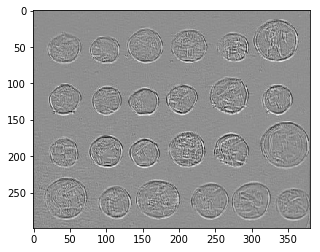

In [20]:
tf.reset_default_graph()

# filter_height, filter_width, in_channels, out_channels
selected_kernel = np.random.normal(size=(5, 5, 3, 10))

init_op = tf.initialize_all_variables()

input_image = tf.placeholder(tf.float32)
convolved = tf.nn.conv2d(input_image, selected_kernel, strides=[1]*4, padding='VALID')

with tf.Session() as sess:
    sess.run(init_op)
    result = sess.run(convolved, feed_dict={input_image:test_image})
    
plt.imshow(result[0][:,:,0], 'gray')

In [22]:
from keras.applications.vgg16 import VGG16

model = VGG16()
print(model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

[[('n02124075', 'Egyptian_cat', 0.69823015),
  ('n02123159', 'tiger_cat', 0.14659362),
  ('n02123045', 'tabby', 0.12827209),
  ('n02127052', 'lynx', 0.017489519),
  ('n03325584', 'feather_boa', 0.00082378736)]]

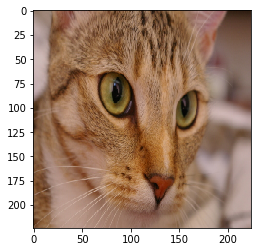

In [25]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize

image = load_img('chelsea.png', target_size=(224, 224))
plt.imshow(image)

image = img_to_array(image)
image = np.expand_dims(image, 0)
image = preprocess_input(image)

prediction = model.predict(image)

decode_predictions(prediction)

[Fine-tuning using pretrained model](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

[Imagenet classes list](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57)

## Seq2Seq for performing addition

In [27]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range


class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [28]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.GRU
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1


model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               54144     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 4, 128)            98688     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 154,380
Trainable params: 154,380
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 1000):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 6s 132us/step - loss: 0.4477 - acc: 0.8377 - val_loss: 0.4397 - val_acc: 0.8372
Q 26+60   T 86   ☑ 86  
Q 286+64  T 350  ☑ 350 
Q 788+811 T 1599 ☒ 1596
Q 183+42  T 225  ☑ 225 
Q 75+400  T 475  ☑ 475 
Q 870+610 T 1480 ☒ 1483
Q 221+48  T 269  ☑ 269 
Q 973+30  T 1003 ☒ 1005
Q 52+590  T 642  ☒ 643 
Q 239+29  T 268  ☒ 267 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 6s 132us/step - loss: 0.4081 - acc: 0.8527 - val_loss: 0.3884 - val_acc: 0.8599
Q 367+686 T 1053 ☒ 1050
Q 25+40   T 65   ☑ 65  
Q 877+89  T 966  ☒ 962 
Q 73+35   T 108  ☒ 107 
Q 865+11  T 876  ☑ 876 
Q 811+9   T 820  ☑ 820 
Q 159+499 T 658  ☒ 653 
Q 829+3   T 832  ☑ 832 
Q 57+633  T 690  ☒ 699 
Q 24+240  T 264  ☑ 264 

-------------------

41472/45000 [==========================>...] - ETA: 0s - loss: 0.0230 - acc: 0.9960

KeyboardInterrupt: 